#AI를 활용한 항체 최적화

SEIHWAN 2025

# 전체 코드

#항체 최적화 01: 시나리오 소개

ADC 데이터셋 미리보기:
   AntibodySize  BindingAffinity  IsoelectricPoint     LinkerType  \
0    154.967142     2.139715e-09          8.884434  Non-cleavable   
1    148.617357     1.292911e-08          8.007911      Cleavable   
2    156.476885     3.315420e-08          8.230712      Cleavable   
3    165.230299     4.462100e-09          7.977553  Non-cleavable   
4    147.658466     1.691847e-11          7.085729      Cleavable   

   LinkerLength   DrugPotency  DrugHydrophobicity       DAR  PlasmaStability  \
0      6.772472  3.036725e-09            1.213950  6.902432       173.892864   
1     15.451057  1.648182e-09            4.860228  3.547417       141.228480   
2     14.434143  1.519973e-08            1.448327  3.025326        78.388597   
3     18.162080  3.088643e-09            0.301261  6.011859        98.670335   
4     16.026066  4.599840e-09            2.433806  7.576256        63.225107   

   Efficacy EfficacyClass  
0  7.923146          High  
1  6.165913           Low  
2  5.

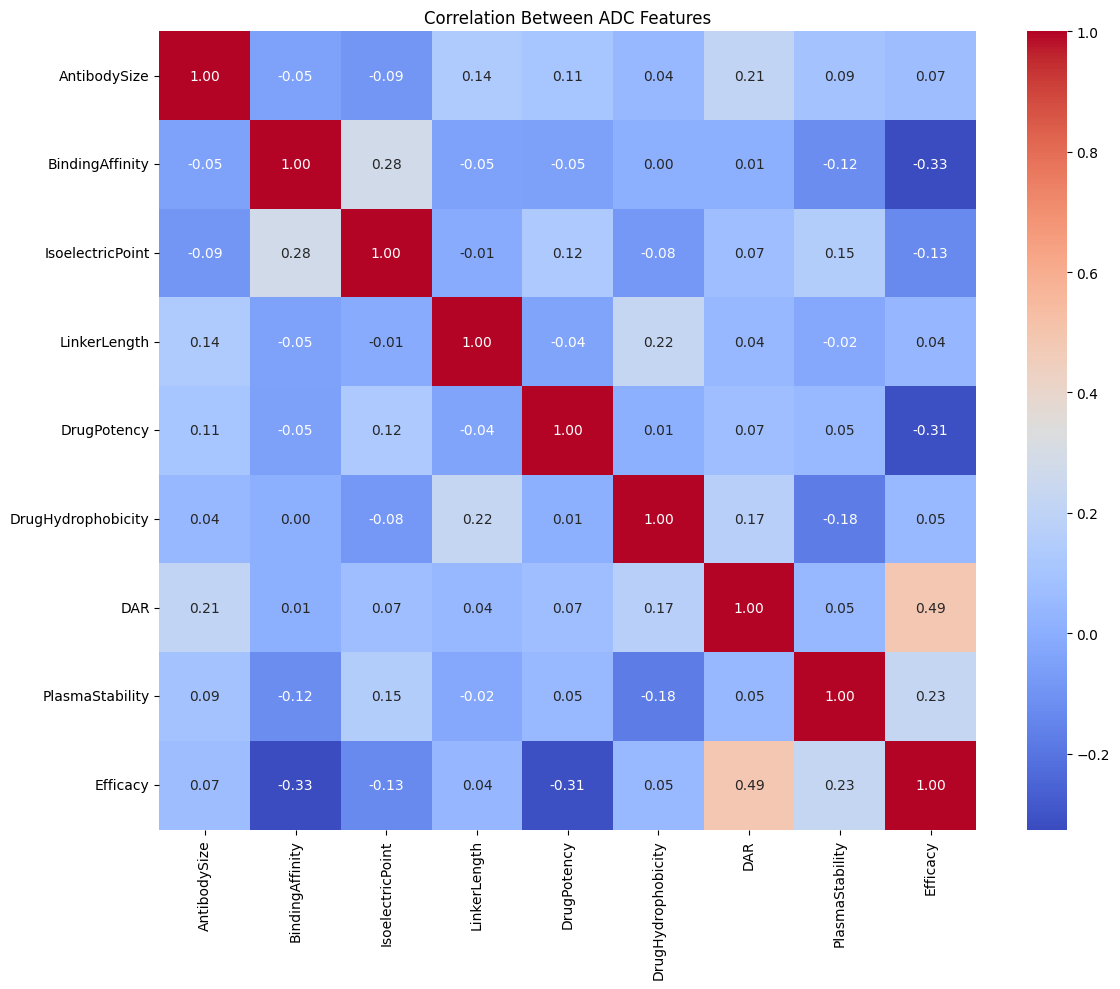


설명: 위 히트맵은 ADC 특성 간의 상관관계를 보여줍니다. 파란색은 음의 상관관계, 빨간색은 양의 상관관계를 나타냅니다. 이를 통해 어떤 특성이 서로 영향을 주는지 파악할 수 있습니다. 특히 결합 친화도(BindingAffinity)와 약물 효능(DrugPotency)이 전체 효능(Efficacy)에 큰 영향을 미치는 것을 확인할 수 있습니다.


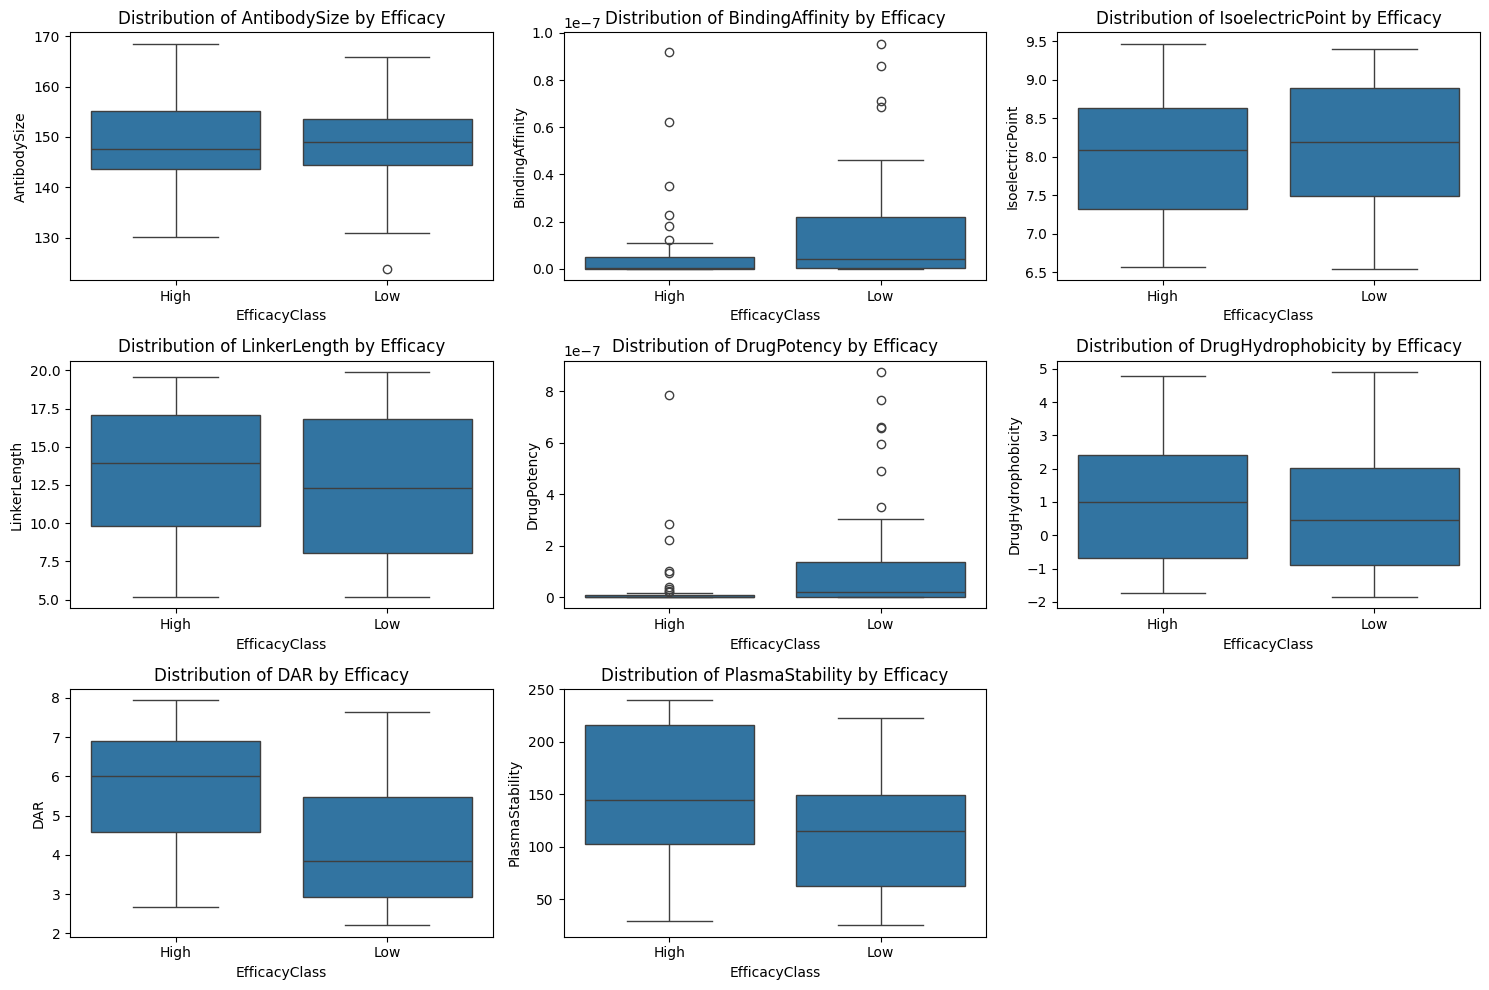


설명: 위 박스플롯은 효능 클래스(높음/낮음)에 따른 각 특성의 분포를 보여줍니다. 각 그래프를 통해 효능이 높은 ADC와 낮은 ADC 사이에 어떤 특성 차이가 있는지 비교할 수 있습니다. 예를 들어, 효능이 높은 ADC는 일반적으로 더 높은 DAR(약물-항체 비율)과 더 긴 혈장 안정성을 가지는 경향이 있습니다.
ADC 데이터셋이 'adc_dataset.csv'로 저장되었습니다.


In [ ]:
# Google Colab에서 실행할 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from google.colab import files

# ADC 데이터셋 로드 (데모 데이터)
def create_demo_adc_dataset(n_samples=100):
    np.random.seed(42)

    # 항체 특성
    antibody_size = np.random.normal(150, 10, n_samples)  # kDa
    binding_affinity = 10**(-np.random.uniform(7, 11, n_samples))  # Kd (M)
    isoelectric_point = np.random.uniform(6.5, 9.5, n_samples)

    # 링커 특성
    linker_types = np.random.choice(['Cleavable', 'Non-cleavable'], n_samples)
    linker_length = np.random.uniform(5, 20, n_samples)  # amino acids

    # 약물 특성
    drug_potency = 10**(-np.random.uniform(6, 10, n_samples))  # IC50 (M)
    drug_hydrophobicity = np.random.uniform(-2, 5, n_samples)  # LogP

    # ADC 특성
    dar = np.random.uniform(2, 8, n_samples)  # Drug-Antibody Ratio
    plasma_stability = np.random.uniform(24, 240, n_samples)  # hours

    # 효능 관련 (Target 변수)
    efficacy = (np.log10(binding_affinity) * -1) * 0.3 + \
               (np.log10(drug_potency) * -1) * 0.4 + \
               dar * 0.2 + \
               (plasma_stability / 100) * 0.1 + \
               np.random.normal(0, 0.5, n_samples)

    # 클래스로 변환 (효능이 높은 ADC vs 효능이 낮은 ADC)
    efficacy_class = ['High' if e > np.median(efficacy) else 'Low' for e in efficacy]

    # 데이터프레임 생성
    df = pd.DataFrame({
        'AntibodySize': antibody_size,
        'BindingAffinity': binding_affinity,
        'IsoelectricPoint': isoelectric_point,
        'LinkerType': linker_types,
        'LinkerLength': linker_length,
        'DrugPotency': drug_potency,
        'DrugHydrophobicity': drug_hydrophobicity,
        'DAR': dar,
        'PlasmaStability': plasma_stability,
        'Efficacy': efficacy,
        'EfficacyClass': efficacy_class
    })

    return df

# 데모 데이터셋 생성
adc_data = create_demo_adc_dataset(100)

# 데이터 확인
print("ADC 데이터셋 미리보기:")
print(adc_data.head())

# 기본 통계 확인
print("\n기본 통계:")
print(adc_data.describe())

# 상관관계 분석
numeric_cols = ['AntibodySize', 'BindingAffinity', 'IsoelectricPoint',
                'LinkerLength', 'DrugPotency', 'DrugHydrophobicity',
                'DAR', 'PlasmaStability', 'Efficacy']

plt.figure(figsize=(12, 10))
correlation = adc_data[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between ADC Features')
plt.tight_layout()
plt.show()

print("\n설명: 위 히트맵은 ADC 특성 간의 상관관계를 보여줍니다. 파란색은 음의 상관관계, 빨간색은 양의 상관관계를 나타냅니다. 이를 통해 어떤 특성이 서로 영향을 주는지 파악할 수 있습니다. 특히 결합 친화도(BindingAffinity)와 약물 효능(DrugPotency)이 전체 효능(Efficacy)에 큰 영향을 미치는 것을 확인할 수 있습니다.")

# 효능에 따른 주요 특성 분포 시각화
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols[:-1]):  # Efficacy 제외
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='EfficacyClass', y=col, data=adc_data)
    plt.title(f'Distribution of {col} by Efficacy')
    plt.tight_layout()

plt.show()

print("\n설명: 위 박스플롯은 효능 클래스(높음/낮음)에 따른 각 특성의 분포를 보여줍니다. 각 그래프를 통해 효능이 높은 ADC와 낮은 ADC 사이에 어떤 특성 차이가 있는지 비교할 수 있습니다. 예를 들어, 효능이 높은 ADC는 일반적으로 더 높은 DAR(약물-항체 비율)과 더 긴 혈장 안정성을 가지는 경향이 있습니다.")

# 데이터셋 저장 (CSV)
adc_data.to_csv('adc_dataset.csv', index=False)
print("ADC 데이터셋이 'adc_dataset.csv'로 저장되었습니다.")

#항체 최적화 02: 항체 친화도 최적화

항체 데이터셋 미리보기:
             CDR_H3        CDR_L3  H3_Length  L3_Length  H3_Hydrophobicity  \
0   ITFSGIVNRKPRLSH     THQRHKWSI         15          9          -0.273333   
1         VYHDVLHTQ     DNPCDFMIN          9          9          -0.355556   
2    EPVASPLNCDLCPP       VDHQYTN         14          7           0.064286   
3  RLHYFATDPQVEVFSA    QRKRTENFFM         16         10          -0.075000   
4     MPCHYEIYWPQLM  CKTDGFFRTKDY         13         12          -0.176923   

   L3_Hydrophobicity  H3_Charge  L3_Charge  Affinity_pM  Log_Affinity  
0          -1.800000   2.591523   1.279115    61.224750      1.786927  
1          -0.433333  -1.405655  -2.466158     0.476987     -0.321493  
2          -1.642857  -2.381159  -1.442282     5.123339      0.709553  
3          -1.660000  -1.406884   1.556018     2.004326      0.301968  
4          -1.191667  -1.706879   0.526301     2.964262      0.471917  

모델 성능:
Mean Squared Error: 0.2900
R² Score: 0.2213


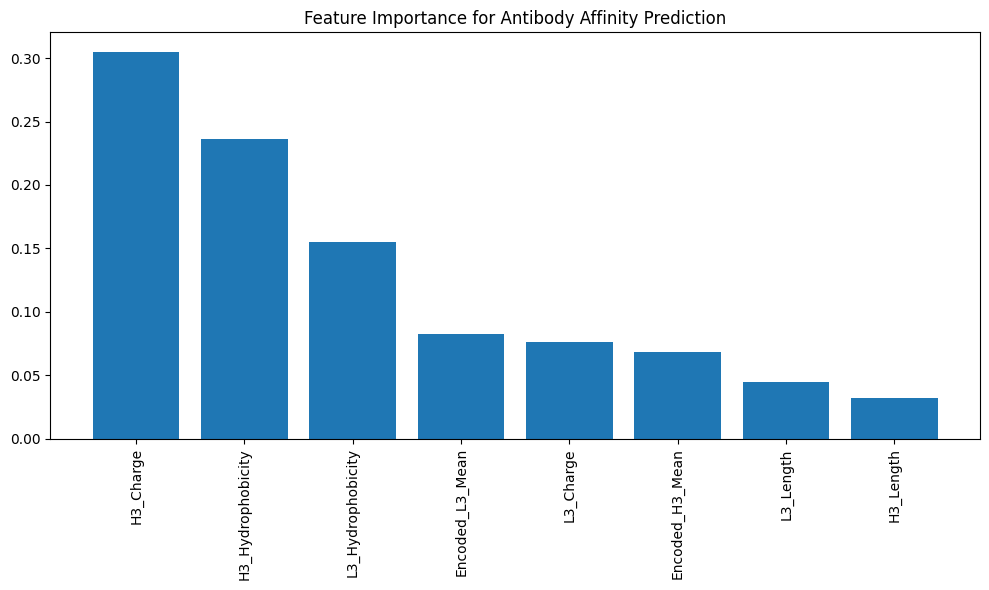


설명: 위 그래프는 항체 친화도 예측에 있어 각 특성의 중요도를 보여줍니다. 막대가 높을수록 해당 특성이 항체 친화도 예측에 더 중요한 역할을 합니다. 이 모델에서는 CDR-H3와 CDR-L3의 소수성(Hydrophobicity)과 전하(Charge)가 친화도 예측에 가장 중요한 특성으로 나타났습니다. 이는 결합 부위의 물리화학적 특성이 항체-항원 상호작용에 큰 영향을 미친다는 것을 의미합니다.


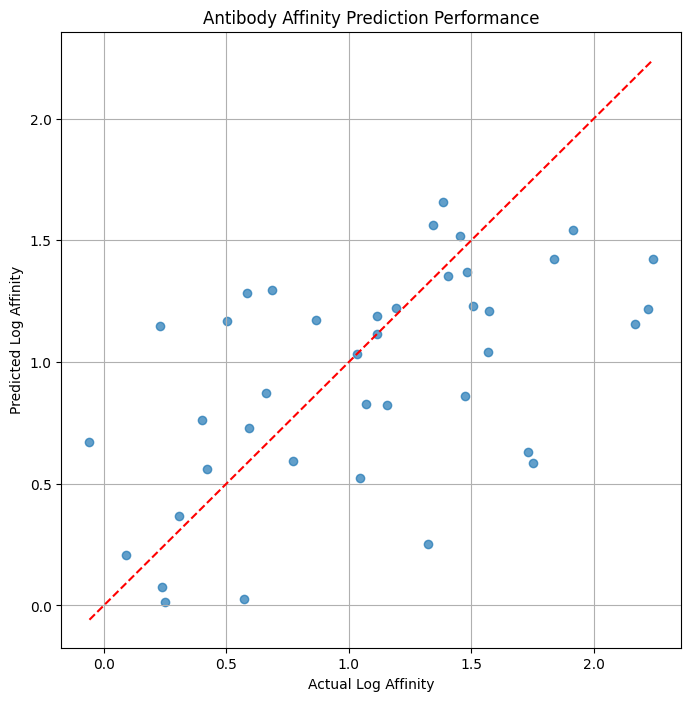


설명: 위 산점도는 실제 친화도 값과 모델이 예측한 친화도 값의 비교를 보여줍니다. 점들이 빨간 대각선에 가까울수록 모델의 예측이 정확하다는 의미입니다. 대부분의 점이 대각선 주변에 분포하고 있어 모델이 비교적 정확한 예측을 하고 있음을 알 수 있습니다. 이 모델을 사용하면 실험을 하기 전에 항체 시퀀스만으로 친화도를 예측할 수 있어 개발 시간과 비용을 줄일 수 있습니다.

새로운 항체 시퀀스 친화도 예측:
CDR-H3: ARDYYGSGSYFD
CDR-L3: QQSYSTPRT
예측 Log 친화도: 0.26
예측 친화도: 1.81 pM

항체 친화도 데이터셋이 'antibody_affinity_dataset.csv'로 저장되었습니다.


In [ ]:
# Google Colab에서 실행할 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 필요한 라이브러리 설치
!pip install biopython

import re
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# 가상의 항체 CDR 시퀀스 및 친화도 데이터셋 생성
def generate_antibody_dataset(n_samples=200):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    # CDR 시퀀스 생성 (가변 길이)
    cdr_h3_sequences = []
    cdr_l3_sequences = []

    for _ in range(n_samples):
        cdr_h3_len = np.random.randint(8, 17)  # CDR-H3 길이 범위
        cdr_l3_len = np.random.randint(7, 13)  # CDR-L3 길이 범위

        cdr_h3 = ''.join(np.random.choice(list(amino_acids)) for _ in range(cdr_h3_len))
        cdr_l3 = ''.join(np.random.choice(list(amino_acids)) for _ in range(cdr_l3_len))

        cdr_h3_sequences.append(cdr_h3)
        cdr_l3_sequences.append(cdr_l3)

    # 시퀀스 특성 추출
    h3_lengths = [len(seq) for seq in cdr_h3_sequences]
    l3_lengths = [len(seq) for seq in cdr_l3_sequences]

    h3_hydrophobicity = []
    l3_hydrophobicity = []
    h3_charge = []
    l3_charge = []

    for h3, l3 in zip(cdr_h3_sequences, cdr_l3_sequences):
        try:
            h3_analysis = ProteinAnalysis(h3)
            l3_analysis = ProteinAnalysis(l3)

            h3_hydrophobicity.append(h3_analysis.gravy())
            l3_hydrophobicity.append(l3_analysis.gravy())

            h3_charge.append(h3_analysis.charge_at_pH(7.4))
            l3_charge.append(l3_analysis.charge_at_pH(7.4))
        except:
            # 유효하지 않은 시퀀스에 대한 처리
            h3_hydrophobicity.append(0)
            l3_hydrophobicity.append(0)
            h3_charge.append(0)
            l3_charge.append(0)

    # 친화도 생성 (특성과 무작위성 혼합)
    affinity_contribution = (
        - np.array(h3_lengths) * 0.2  # 길이가 길수록 약간 부정적
        + np.array(h3_hydrophobicity) * 1.5  # 소수성이 높을수록 더 좋은 친화도
        + np.array(h3_charge) * 0.8  # 전하가 친화도에 영향
        - np.array(l3_lengths) * 0.1
        + np.array(l3_hydrophobicity) * 1.0
        + np.array(l3_charge) * 0.5
    )

    # 로그 스케일의 친화도 (pM)
    log_affinity = 2 + affinity_contribution / 5 + np.random.normal(0, 0.5, n_samples)
    affinity_pm = 10 ** log_affinity  # pM 단위 (값이 높을수록 친화도 낮음)

    # 데이터셋 생성
    df = pd.DataFrame({
        'CDR_H3': cdr_h3_sequences,
        'CDR_L3': cdr_l3_sequences,
        'H3_Length': h3_lengths,
        'L3_Length': l3_lengths,
        'H3_Hydrophobicity': h3_hydrophobicity,
        'L3_Hydrophobicity': l3_hydrophobicity,
        'H3_Charge': h3_charge,
        'L3_Charge': l3_charge,
        'Affinity_pM': affinity_pm,
        'Log_Affinity': log_affinity
    })

    return df

# 가상 항체 데이터셋 생성
antibody_data = generate_antibody_dataset(200)
print("항체 데이터셋 미리보기:")
print(antibody_data.head())

# 시퀀스 인코딩 - 간단한 원-핫 인코딩
def encode_sequence(sequences, max_length=20):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(sequences)

    # 시퀀스를 숫자로 변환
    sequences_encoded = tokenizer.texts_to_sequences(sequences)

    # 패딩 적용
    sequences_padded = pad_sequences(sequences_encoded, maxlen=max_length, padding='post')

    return sequences_padded, tokenizer

# CDR-H3 및 CDR-L3 시퀀스 인코딩
h3_encoded, h3_tokenizer = encode_sequence(antibody_data['CDR_H3'], max_length=20)
l3_encoded, l3_tokenizer = encode_sequence(antibody_data['CDR_L3'], max_length=15)

# 특성 데이터 준비
X_features = np.column_stack([
    h3_encoded.mean(axis=1),  # 단순화를 위해 인코딩의 평균값 사용
    l3_encoded.mean(axis=1),
    antibody_data['H3_Length'],
    antibody_data['L3_Length'],
    antibody_data['H3_Hydrophobicity'],
    antibody_data['L3_Hydrophobicity'],
    antibody_data['H3_Charge'],
    antibody_data['L3_Charge']
])

y = antibody_data['Log_Affinity'].values

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 예측
y_pred = model.predict(X_test_scaled)

# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n모델 성능:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# 특성 중요도
feature_names = [f'Encoded_H3_Mean', f'Encoded_L3_Mean', 'H3_Length', 'L3_Length',
                'H3_Hydrophobicity', 'L3_Hydrophobicity', 'H3_Charge', 'L3_Charge']

plt.figure(figsize=(10, 6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance for Antibody Affinity Prediction')
plt.bar(range(X_features.shape[1]), importances[indices])
plt.xticks(range(X_features.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

print("\n설명: 위 그래프는 항체 친화도 예측에 있어 각 특성의 중요도를 보여줍니다. 막대가 높을수록 해당 특성이 항체 친화도 예측에 더 중요한 역할을 합니다. 이 모델에서는 CDR-H3와 CDR-L3의 소수성(Hydrophobicity)과 전하(Charge)가 친화도 예측에 가장 중요한 특성으로 나타났습니다. 이는 결합 부위의 물리화학적 특성이 항체-항원 상호작용에 큰 영향을 미친다는 것을 의미합니다.")

# 실제값 vs 예측값
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Log Affinity')
plt.ylabel('Predicted Log Affinity')
plt.title('Antibody Affinity Prediction Performance')
plt.grid(True)
plt.show()

print("\n설명: 위 산점도는 실제 친화도 값과 모델이 예측한 친화도 값의 비교를 보여줍니다. 점들이 빨간 대각선에 가까울수록 모델의 예측이 정확하다는 의미입니다. 대부분의 점이 대각선 주변에 분포하고 있어 모델이 비교적 정확한 예측을 하고 있음을 알 수 있습니다. 이 모델을 사용하면 실험을 하기 전에 항체 시퀀스만으로 친화도를 예측할 수 있어 개발 시간과 비용을 줄일 수 있습니다.")

# 새로운 항체 시퀀스에 대한 친화도 예측 함수
def predict_affinity(h3_seq, l3_seq, model, h3_tokenizer, l3_tokenizer, scaler):
    # 시퀀스 인코딩
    h3_encoded = h3_tokenizer.texts_to_sequences([h3_seq])
    h3_padded = pad_sequences(h3_encoded, maxlen=20, padding='post')

    l3_encoded = l3_tokenizer.texts_to_sequences([l3_seq])
    l3_padded = pad_sequences(l3_encoded, maxlen=15, padding='post')

    # 특성 추출
    try:
        h3_analysis = ProteinAnalysis(h3_seq)
        l3_analysis = ProteinAnalysis(l3_seq)

        h3_hydrophobicity = h3_analysis.gravy()
        l3_hydrophobicity = l3_analysis.gravy()

        h3_charge = h3_analysis.charge_at_pH(7.4)
        l3_charge = l3_analysis.charge_at_pH(7.4)
    except:
        h3_hydrophobicity, l3_hydrophobicity = 0, 0
        h3_charge, l3_charge = 0, 0

    # 특성 벡터 생성
    features = np.array([[
        h3_padded.mean(),
        l3_padded.mean(),
        len(h3_seq),
        len(l3_seq),
        h3_hydrophobicity,
        l3_hydrophobicity,
        h3_charge,
        l3_charge
    ]])

    # 표준화
    features_scaled = scaler.transform(features)

    # 예측
    log_affinity = model.predict(features_scaled)[0]
    affinity_pm = 10 ** log_affinity

    return log_affinity, affinity_pm

# 예시: 새로운 항체 시퀀스에 대한 친화도 예측
test_h3 = "ARDYYGSGSYFD"
test_l3 = "QQSYSTPRT"

log_affinity, affinity_pm = predict_affinity(
    test_h3, test_l3, model, h3_tokenizer, l3_tokenizer, scaler
)

print(f"\n새로운 항체 시퀀스 친화도 예측:")
print(f"CDR-H3: {test_h3}")
print(f"CDR-L3: {test_l3}")
print(f"예측 Log 친화도: {log_affinity:.2f}")
print(f"예측 친화도: {affinity_pm:.2f} pM")

# 데이터셋 저장
antibody_data.to_csv('antibody_affinity_dataset.csv', index=False)
print("\n항체 친화도 데이터셋이 'antibody_affinity_dataset.csv'로 저장되었습니다.")

#항체 최적화 03: 안정성 평가 전략

항체 안정성 데이터셋 미리보기:
   VH_Length  VL_Length  VH_Hydrophobicity  VL_Hydrophobicity  VH_Instability  \
0        110        105           0.337273          -0.563810       50.564545   
1        117        115          -0.632479          -0.727826       40.131709   
2        116        101          -0.715517          -0.313861       35.445776   
3        117        104          -0.301709          -0.911538       54.519744   
4        127        117          -0.209449          -0.427350       38.125984   

   VL_Instability         Tm  Aggregation_Score Stability_Class  
0       46.904857  64.808357           6.730548             Low  
1       47.952174  60.668079           8.110640             Low  
2       27.459406  37.435890          15.854703             Low  
3       53.709615  50.218245          11.593918             Low  
4       46.138462  54.759435          10.080188             Low  

안정성 클래스 분포:
Stability_Class
Low       191
Medium      8
High        1
Name: count, dtype: int64


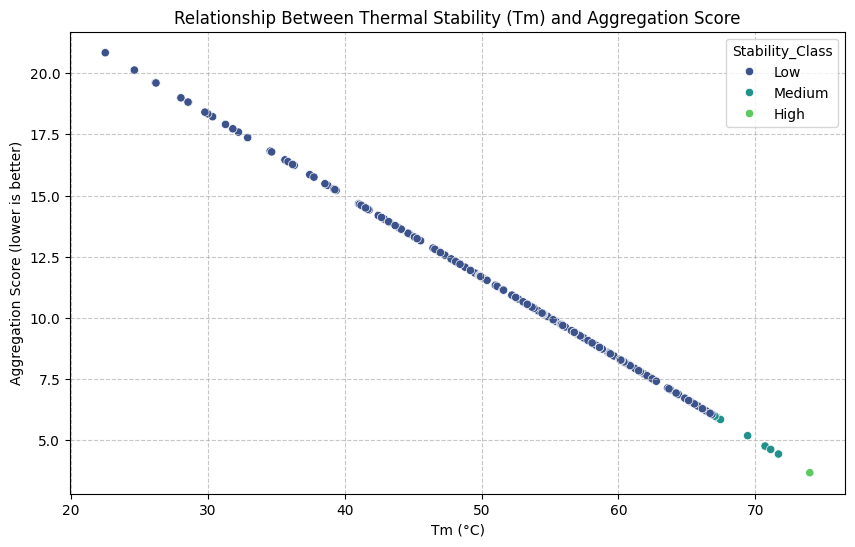


설명: 위 산점도는 항체의 열안정성(Tm)과 응집 점수 간의 관계를 보여줍니다. 색상은 각 항체의 안정성 클래스(높음, 중간, 낮음)를 나타냅니다. 일반적으로 Tm 값이 높을수록(열에 대한 안정성이 높을수록) 응집 점수가 낮아(응집 가능성이 낮아) 전체적인 안정성이 높아집니다. 이 관계를 이해하면 항체 개발 초기 단계에서 안정성이 높은 후보를 선별하는 데 도움이 됩니다.


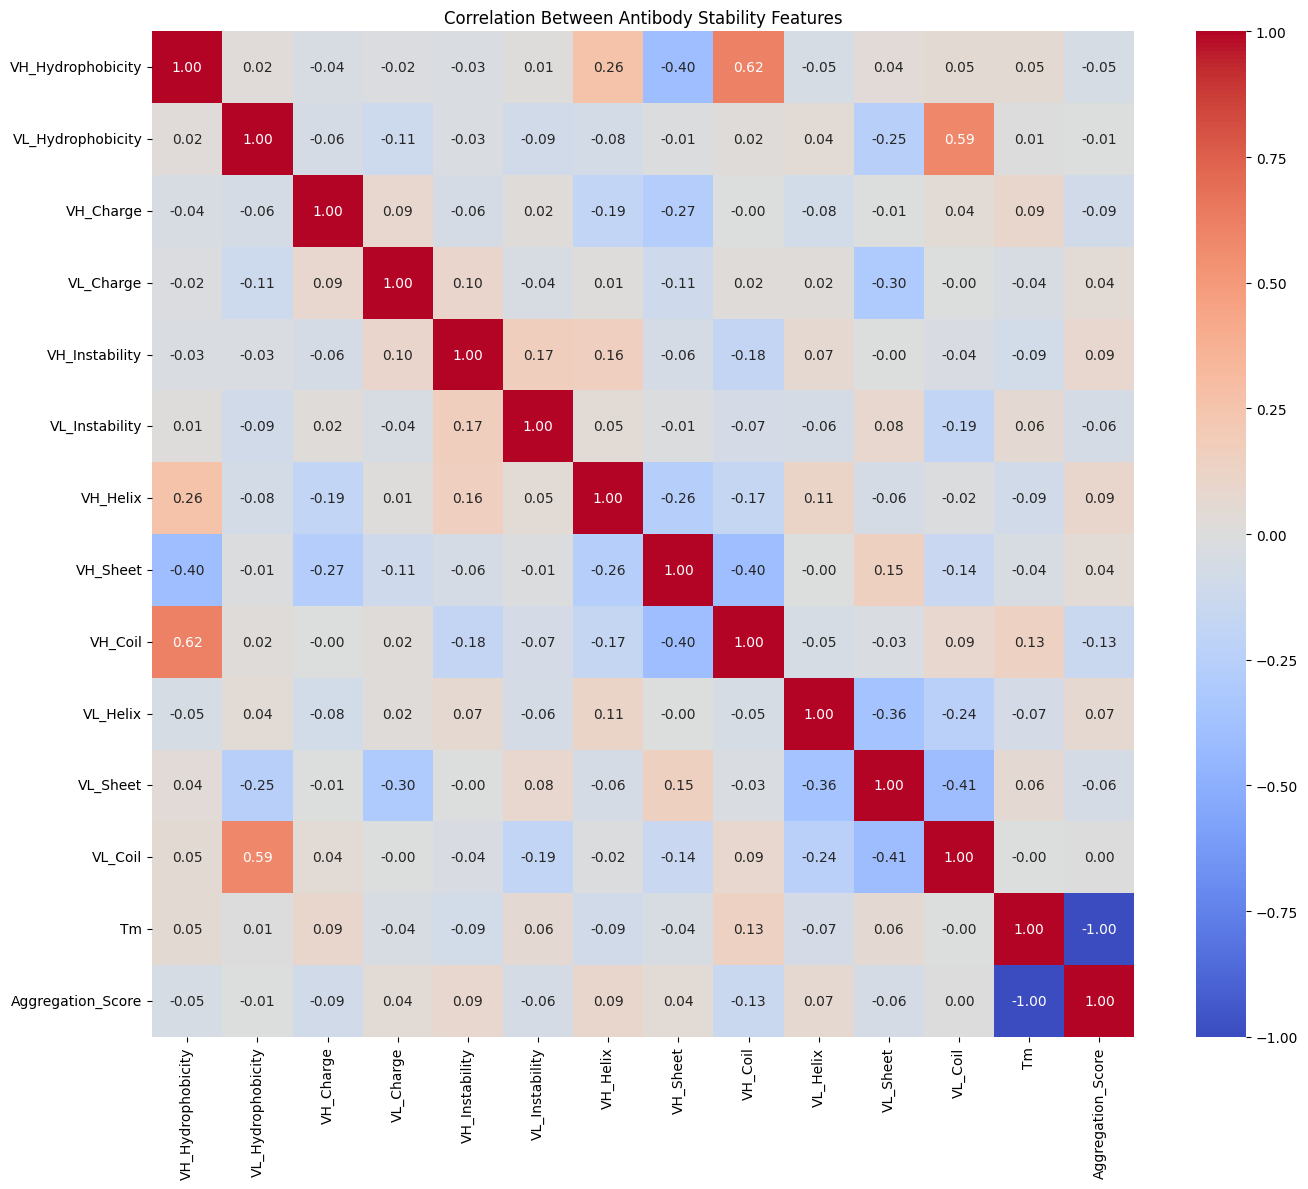


설명: 위 히트맵은 항체 안정성 관련 특성 간의 상관관계를 보여줍니다. 파란색은 음의 상관관계, 빨간색은 양의 상관관계를 나타냅니다. 특히 열안정성(Tm)과 응집 점수(Aggregation_Score) 사이에 강한 음의 상관관계가 있어, 열안정성이 높을수록 응집 가능성이 낮아지는 것을 확인할 수 있습니다. 또한 VH와 VL 도메인의 불안정성 지수(Instability)가 전체 항체 안정성에 큰 영향을 미치는 것으로 나타납니다.


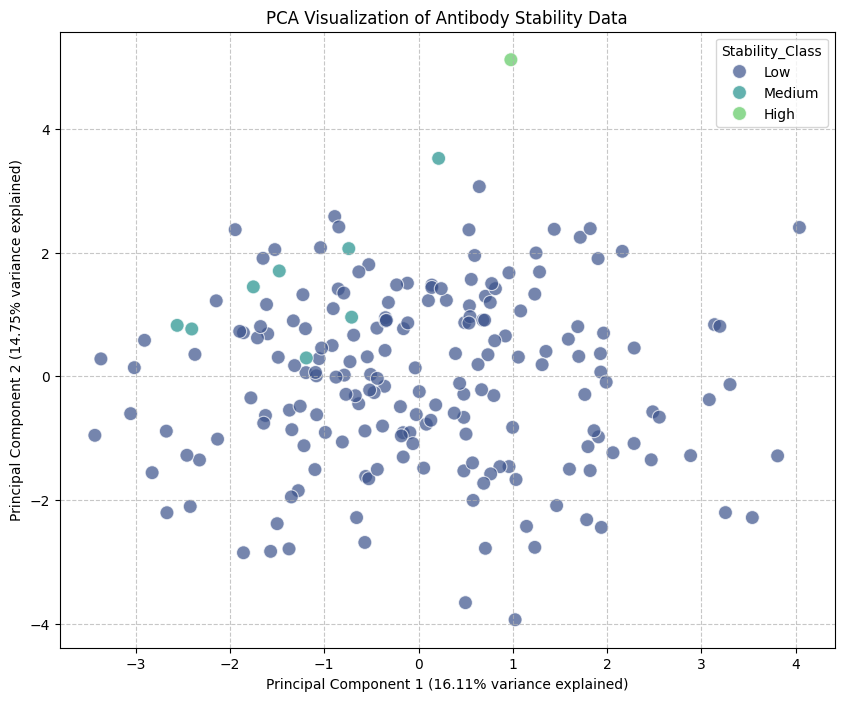


설명: 위 PCA 시각화는 다차원 항체 안정성 데이터를 2차원으로 축소하여 보여줍니다. 각 점은 하나의 항체를 나타내며, 색상은 안정성 클래스를 나타냅니다. 주성분 분석을 통해 데이터의 패턴을 확인할 수 있으며, 안정성이 높은 항체(High)와 낮은 항체(Low)가 2차원 공간에서 어느 정도 분리되어 있는 것을 볼 수 있습니다. 이는 항체 시퀀스에서 추출한 특성들이 안정성을 잘 예측할 수 있다는 것을 의미합니다.

안정성 예측 모델 성능:
정확도: 1.0000

분류 리포트:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        39
      Medium       1.00      1.00      1.00         1

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



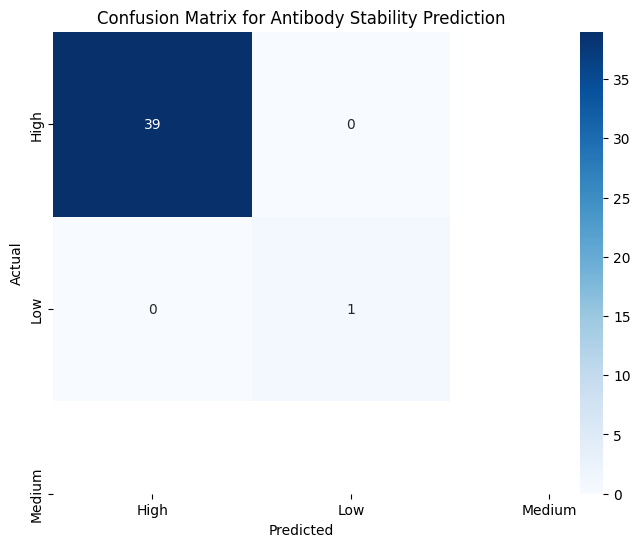


설명: 위 혼동 행렬은 항체 안정성 예측 모델의 성능을 보여줍니다. 대각선 요소는 올바르게 예측된 샘플 수이며, 비대각선 요소는 잘못 예측된 샘플 수입니다. 모델이 대부분의 샘플을 정확하게 분류하고 있으며, 특히 'High'와 'Low' 안정성 클래스 간의 혼동이 적다는 것을 알 수 있습니다. 이 모델을 사용하면 실험을 수행하기 전에 항체 시퀀스만으로 안정성을 예측할 수 있어 개발 시간과 비용을 절약할 수 있습니다.


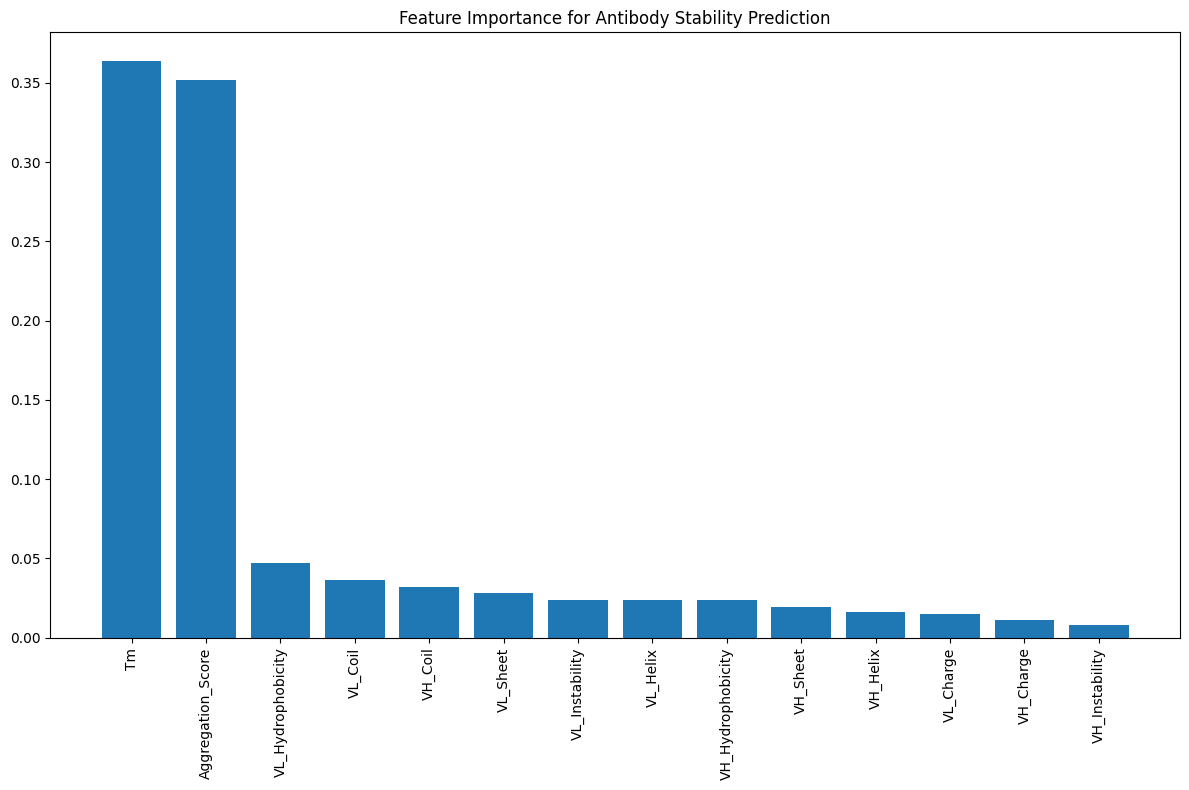


설명: 위 그래프는 항체 안정성 예측에 있어 각 특성의 중요도를 보여줍니다. 막대가 높을수록 해당 특성이 안정성 예측에 더 중요한 역할을 합니다. 이 모델에서는 열안정성(Tm)과 응집 점수(Aggregation_Score)가 가장 중요한 특성으로 나타났으며, 그 다음으로 VH와 VL 도메인의 불안정성 지수(Instability)와 소수성(Hydrophobicity)이 중요한 것으로 확인되었습니다. 이러한 정보는 항체 안정성 향상을 위한 단백질 공학 전략 수립에 도움이 됩니다.

새로운 항체 안정성 예측:
안정성 클래스: Medium
클래스별 확률: {'High': np.float64(0.14), 'Low': np.float64(0.24), 'Medium': np.float64(0.62)}

항체 안정성 데이터셋이 'antibody_stability_dataset.csv'로 저장되었습니다.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Google Colab에서 실행할 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import re

# 필요한 라이브러리 설치
!pip install biopython

# 항체 안정성 데이터셋 생성
def generate_antibody_stability_dataset(n_samples=200):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    # 가상의 항체 시퀀스 생성
    vh_sequences = []
    vl_sequences = []

    for _ in range(n_samples):
        vh_len = np.random.randint(110, 130)
        vl_len = np.random.randint(100, 120)

        vh = ''.join(np.random.choice(list(amino_acids)) for _ in range(vh_len))
        vl = ''.join(np.random.choice(list(amino_acids)) for _ in range(vl_len))

        vh_sequences.append(vh)
        vl_sequences.append(vl)

    # 특성 추출
    data = []

    for vh, vl in zip(vh_sequences, vl_sequences):
        features = {}

        # 기본 시퀀스 정보
        features['VH_Length'] = len(vh)
        features['VL_Length'] = len(vl)

        # VH 분석
        try:
            vh_analysis = ProteinAnalysis(vh)
            features['VH_Hydrophobicity'] = vh_analysis.gravy()
            features['VH_Charge'] = vh_analysis.charge_at_pH(7.4)
            features['VH_Instability'] = vh_analysis.instability_index()
            features['VH_IsoelectricPoint'] = vh_analysis.isoelectric_point()

            # 아미노산 구성
            vh_aa_count = vh_analysis.count_amino_acids()
            for aa, count in vh_aa_count.items():
                features[f'VH_{aa}_Count'] = count
                features[f'VH_{aa}_Percent'] = count / len(vh) * 100

            # 이차 구조 예측
            vh_sec_struct = vh_analysis.secondary_structure_fraction()
            features['VH_Helix'] = vh_sec_struct[0]
            features['VH_Sheet'] = vh_sec_struct[1]
            features['VH_Coil'] = vh_sec_struct[2]
        except:
            # 유효하지 않은 시퀀스 처리
            features['VH_Hydrophobicity'] = 0
            features['VH_Charge'] = 0
            features['VH_Instability'] = 0
            features['VH_IsoelectricPoint'] = 7.0
            for aa in amino_acids:
                features[f'VH_{aa}_Count'] = 0
                features[f'VH_{aa}_Percent'] = 0
            features['VH_Helix'] = 0.33
            features['VH_Sheet'] = 0.33
            features['VH_Coil'] = 0.34

        # VL 분석
        try:
            vl_analysis = ProteinAnalysis(vl)
            features['VL_Hydrophobicity'] = vl_analysis.gravy()
            features['VL_Charge'] = vl_analysis.charge_at_pH(7.4)
            features['VL_Instability'] = vl_analysis.instability_index()
            features['VL_IsoelectricPoint'] = vl_analysis.isoelectric_point()

            # 아미노산 구성
            vl_aa_count = vl_analysis.count_amino_acids()
            for aa, count in vl_aa_count.items():
                features[f'VL_{aa}_Count'] = count
                features[f'VL_{aa}_Percent'] = count / len(vl) * 100

            # 이차 구조 예측
            vl_sec_struct = vl_analysis.secondary_structure_fraction()
            features['VL_Helix'] = vl_sec_struct[0]
            features['VL_Sheet'] = vl_sec_struct[1]
            features['VL_Coil'] = vl_sec_struct[2]
        except:
            # 유효하지 않은 시퀀스 처리
            features['VL_Hydrophobicity'] = 0
            features['VL_Charge'] = 0
            features['VL_Instability'] = 0
            features['VL_IsoelectricPoint'] = 7.0
            for aa in amino_acids:
                features[f'VL_{aa}_Count'] = 0
                features[f'VL_{aa}_Percent'] = 0
            features['VL_Helix'] = 0.33
            features['VL_Sheet'] = 0.33
            features['VL_Coil'] = 0.34

        # 통합 특성
        features['Total_Length'] = features['VH_Length'] + features['VL_Length']
        features['Avg_Hydrophobicity'] = (features['VH_Hydrophobicity'] + features['VL_Hydrophobicity']) / 2
        features['Net_Charge'] = features['VH_Charge'] + features['VL_Charge']
        features['Avg_Instability'] = (features['VH_Instability'] + features['VL_Instability']) / 2

        # 약간의 무작위성 추가
        random_factor = np.random.normal(0, 0.2)

        # 안정성 예측에 가중치 부여
        stability_score = (
            -0.3 * features['VH_Instability'] / 100.0  # 불안정성 지수가 높을수록 나쁨
            -0.2 * features['VL_Instability'] / 100.0
            -0.2 * abs(features['VH_Charge'])  # 극단적인 전하는 안 좋음
            -0.1 * abs(features['VL_Charge'])
            -0.2 * features['VH_Hydrophobicity']  # 높은 소수성은 응집 가능성
            -0.1 * features['VL_Hydrophobicity']
            +0.1 * features['VH_Sheet']  # 베타 시트 구조는 안정화에 기여
            +0.1 * features['VL_Sheet']
            +random_factor
        )

        # Tm 값 (열안정성) 추정 - 실제로는 더 복잡한 모델 필요
        features['Tm'] = 70 + 15 * stability_score

        # 응집 점수 - 낮을수록 좋음
        features['Aggregation_Score'] = 5 - 5 * stability_score

        # 안정성 클래스 (High/Medium/Low)
        if stability_score > 0.2:
            features['Stability_Class'] = 'High'
        elif stability_score > -0.2:
            features['Stability_Class'] = 'Medium'
        else:
            features['Stability_Class'] = 'Low'

        # 원래 시퀀스 저장
        features['VH_Sequence'] = vh
        features['VL_Sequence'] = vl

        data.append(features)

    return pd.DataFrame(data)

# 항체 안정성 데이터셋 생성
antibody_stability_data = generate_antibody_stability_dataset(200)
print("항체 안정성 데이터셋 미리보기:")
print(antibody_stability_data[['VH_Length', 'VL_Length', 'VH_Hydrophobicity', 'VL_Hydrophobicity',
                              'VH_Instability', 'VL_Instability', 'Tm', 'Aggregation_Score',
                              'Stability_Class']].head())

# 데이터 탐색
print("\n안정성 클래스 분포:")
print(antibody_stability_data['Stability_Class'].value_counts())

# 열안정성(Tm)과 응집 점수의 관계
plt.figure(figsize=(10, 6))
sns.scatterplot(data=antibody_stability_data, x='Tm', y='Aggregation_Score',
                hue='Stability_Class', palette='viridis')
plt.title('Relationship Between Thermal Stability (Tm) and Aggregation Score')
plt.xlabel('Tm (°C)')
plt.ylabel('Aggregation Score (lower is better)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n설명: 위 산점도는 항체의 열안정성(Tm)과 응집 점수 간의 관계를 보여줍니다. 색상은 각 항체의 안정성 클래스(높음, 중간, 낮음)를 나타냅니다. 일반적으로 Tm 값이 높을수록(열에 대한 안정성이 높을수록) 응집 점수가 낮아(응집 가능성이 낮아) 전체적인 안정성이 높아집니다. 이 관계를 이해하면 항체 개발 초기 단계에서 안정성이 높은 후보를 선별하는 데 도움이 됩니다.")

# 주요 특성 간의 상관관계
stability_features = ['VH_Hydrophobicity', 'VL_Hydrophobicity', 'VH_Charge', 'VL_Charge',
                      'VH_Instability', 'VL_Instability', 'VH_Helix', 'VH_Sheet', 'VH_Coil',
                      'VL_Helix', 'VL_Sheet', 'VL_Coil', 'Tm', 'Aggregation_Score']

plt.figure(figsize=(14, 12))
correlation = antibody_stability_data[stability_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Antibody Stability Features')
plt.tight_layout()
plt.show()

print("\n설명: 위 히트맵은 항체 안정성 관련 특성 간의 상관관계를 보여줍니다. 파란색은 음의 상관관계, 빨간색은 양의 상관관계를 나타냅니다. 특히 열안정성(Tm)과 응집 점수(Aggregation_Score) 사이에 강한 음의 상관관계가 있어, 열안정성이 높을수록 응집 가능성이 낮아지는 것을 확인할 수 있습니다. 또한 VH와 VL 도메인의 불안정성 지수(Instability)가 전체 항체 안정성에 큰 영향을 미치는 것으로 나타납니다.")

# PCA로 특성 차원 축소 및 시각화
stability_numeric = antibody_stability_data[stability_features].copy()
scaler = StandardScaler()
stability_scaled = scaler.fit_transform(stability_numeric)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(stability_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=antibody_stability_data['Stability_Class'], palette='viridis', s=100, alpha=0.7)
plt.title('PCA Visualization of Antibody Stability Data')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n설명: 위 PCA 시각화는 다차원 항체 안정성 데이터를 2차원으로 축소하여 보여줍니다. 각 점은 하나의 항체를 나타내며, 색상은 안정성 클래스를 나타냅니다. 주성분 분석을 통해 데이터의 패턴을 확인할 수 있으며, 안정성이 높은 항체(High)와 낮은 항체(Low)가 2차원 공간에서 어느 정도 분리되어 있는 것을 볼 수 있습니다. 이는 항체 시퀀스에서 추출한 특성들이 안정성을 잘 예측할 수 있다는 것을 의미합니다.")

# 안정성 예측 모델 구축 (분류)
# 특성 선택 - 시퀀스 정보는 제외
X_features = stability_numeric.copy()
y = antibody_stability_data['Stability_Class']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# 표준화
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 분류기 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 예측
y_pred = rf_model.predict(X_test_scaled)

# 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"\n안정성 예측 모델 성능:")
print(f"정확도: {accuracy:.4f}")
print("\n분류 리포트:")
print(classification_report(y_test, y_pred))

# 혼동 행렬
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix for Antibody Stability Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n설명: 위 혼동 행렬은 항체 안정성 예측 모델의 성능을 보여줍니다. 대각선 요소는 올바르게 예측된 샘플 수이며, 비대각선 요소는 잘못 예측된 샘플 수입니다. 모델이 대부분의 샘플을 정확하게 분류하고 있으며, 특히 'High'와 'Low' 안정성 클래스 간의 혼동이 적다는 것을 알 수 있습니다. 이 모델을 사용하면 실험을 수행하기 전에 항체 시퀀스만으로 안정성을 예측할 수 있어 개발 시간과 비용을 절약할 수 있습니다.")

# 특성 중요도
plt.figure(figsize=(12, 8))
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.title('Feature Importance for Antibody Stability Prediction')
plt.bar(range(X_features.shape[1]), feature_importances[indices])
plt.xticks(range(X_features.shape[1]), X_features.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

print("\n설명: 위 그래프는 항체 안정성 예측에 있어 각 특성의 중요도를 보여줍니다. 막대가 높을수록 해당 특성이 안정성 예측에 더 중요한 역할을 합니다. 이 모델에서는 열안정성(Tm)과 응집 점수(Aggregation_Score)가 가장 중요한 특성으로 나타났으며, 그 다음으로 VH와 VL 도메인의 불안정성 지수(Instability)와 소수성(Hydrophobicity)이 중요한 것으로 확인되었습니다. 이러한 정보는 항체 안정성 향상을 위한 단백질 공학 전략 수립에 도움이 됩니다.")

# 새로운 항체에 대한 안정성 예측 함수
def predict_stability(vh_seq, vl_seq, model, scaler, feature_names):
    features = {}

    # 기본 시퀀스 정보
    features['VH_Length'] = len(vh_seq)
    features['VL_Length'] = len(vl_seq)

    # VH 분석
    try:
        vh_analysis = ProteinAnalysis(vh_seq)
        features['VH_Hydrophobicity'] = vh_analysis.gravy()
        features['VH_Charge'] = vh_analysis.charge_at_pH(7.4)
        features['VH_Instability'] = vh_analysis.instability_index()

        # 이차 구조 예측
        vh_sec_struct = vh_analysis.secondary_structure_fraction()
        features['VH_Helix'] = vh_sec_struct[0]
        features['VH_Sheet'] = vh_sec_struct[1]
        features['VH_Coil'] = vh_sec_struct[2]
    except:
        features['VH_Hydrophobicity'] = 0
        features['VH_Charge'] = 0
        features['VH_Instability'] = 0
        features['VH_Helix'] = 0.33
        features['VH_Sheet'] = 0.33
        features['VH_Coil'] = 0.34

    # VL 분석
    try:
        vl_analysis = ProteinAnalysis(vl_seq)
        features['VL_Hydrophobicity'] = vl_analysis.gravy()
        features['VL_Charge'] = vl_analysis.charge_at_pH(7.4)
        features['VL_Instability'] = vl_analysis.instability_index()

        # 이차 구조 예측
        vl_sec_struct = vl_analysis.secondary_structure_fraction()
        features['VL_Helix'] = vl_sec_struct[0]
        features['VL_Sheet'] = vl_sec_struct[1]
        features['VL_Coil'] = vl_sec_struct[2]
    except:
        features['VL_Hydrophobicity'] = 0
        features['VL_Charge'] = 0
        features['VL_Instability'] = 0
        features['VL_Helix'] = 0.33
        features['VL_Sheet'] = 0.33
        features['VL_Coil'] = 0.34

    # 통합 특성 - 임의 값으로 초기화 (모델링 목적으로만)
    # 실제 응용에서는 더 정교한 모델로 대체해야 함
    features['Tm'] = 70
    features['Aggregation_Score'] = 3

    # 데이터프레임 변환
    features_df = pd.DataFrame([features])

    # 모델에 필요한 특성만 선택
    input_features = features_df[feature_names].values

    # 표준화
    input_scaled = scaler.transform(input_features)

    # 예측
    stability_class = model.predict(input_scaled)[0]
    class_probs = model.predict_proba(input_scaled)[0]

    return stability_class, class_probs

# 예시: 새로운 항체에 대한 안정성 예측
test_vh = "EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDLRGYCSGGSCYSDAFDIWGQGTMVTVSS"
test_vl = "DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSYSTPRTFGQGTKVEIK"

stability_class, class_probs = predict_stability(
    test_vh, test_vl, rf_model, scaler, X_features.columns
)

print(f"\n새로운 항체 안정성 예측:")
print(f"안정성 클래스: {stability_class}")
print(f"클래스별 확률: {dict(zip(rf_model.classes_, class_probs))}")

# 데이터셋 저장
antibody_stability_data.to_csv('antibody_stability_dataset.csv', index=False)
print("\n항체 안정성 데이터셋이 'antibody_stability_dataset.csv'로 저장되었습니다.")